Files already downloaded and verified
Number of samples in forget class (airplane): 1
Number of samples in remember classes: 4999
Number of parameters: 13308044, 13.308044M


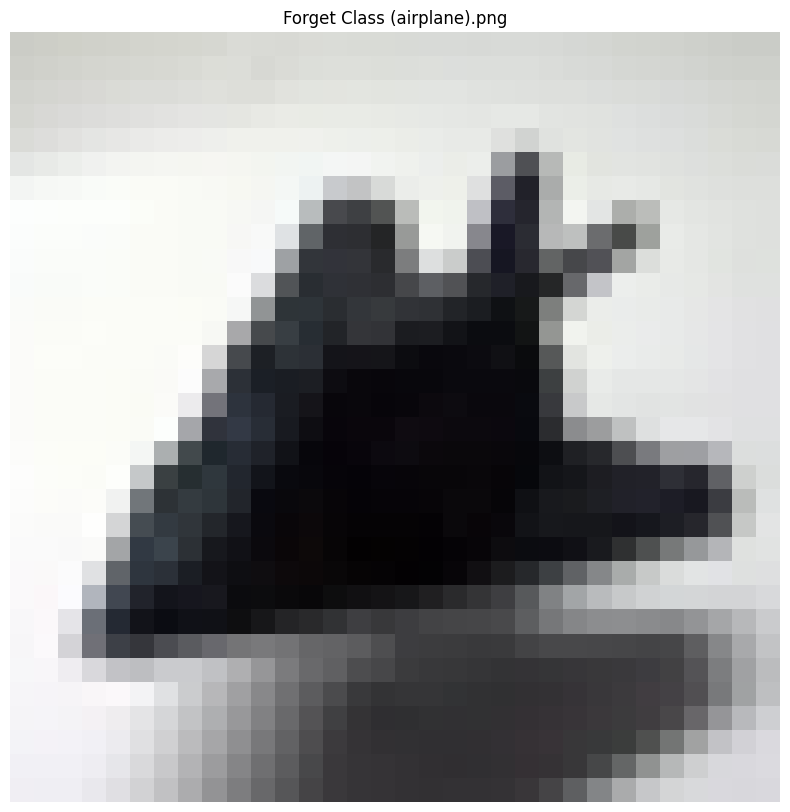

In [8]:
import argparse
import random
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
from losses_minrf import elbo_loss, kl_divergence, compute_elbo_for_sample, compute_nll, negative_log_likelihood

class RF:
    def __init__(self, model, ln=True):
        self.model = model
        self.ln = ln

    def forward(self, x, cond):
        b = x.size(0)
        if self.ln:
            nt = torch.randn((b,)).to(x.device)
            t = torch.sigmoid(nt)
        else:
            t = torch.rand((b,)).to(x.device)
        texp = t.view([b, *([1] * len(x.shape[1:]))])
        z1 = torch.randn_like(x)
        zt = (1 - texp) * x + texp * z1
        vtheta = self.model(zt, t, cond)
        batchwise_mse = ((z1 - x - vtheta) ** 2).mean(dim=list(range(1, len(x.shape))))
        tlist = batchwise_mse.detach().cpu().reshape(-1).tolist()
        ttloss = [(tv, tloss) for tv, tloss in zip(t, tlist)]
        return batchwise_mse.mean(), ttloss

    @torch.no_grad()
    def sample(self, z, cond, null_cond=None, sample_steps=50, cfg=2.0):
        b = z.size(0)
        dt = 1.0 / sample_steps
        dt = torch.tensor([dt] * b).to(z.device).view([b, *([1] * len(z.shape[1:]))])
        images = [z]
        for i in range(sample_steps, 0, -1):
            t = i / sample_steps
            t = torch.tensor([t] * b).to(z.device)

            vc = self.model(z, t, cond)
            if null_cond is not None:
                vu = self.model(z, t, null_cond)
                vc = vu + cfg * (vc - vu)

            z = z - dt * vc
            images.append(z)
        return images

    def reverse_sample(self, y1, cond, null_cond=None, sample_steps=2, cfg=2.0):
        b = y1.size(0)
        dt = 1.0 / sample_steps
        dt = torch.tensor([dt] * b).to(y1.device).view([b, *([1] * len(y1.shape[1:]))])

        z = y1
        for i in range(1, sample_steps + 1):
            t = i / sample_steps
            t = torch.tensor([t] * b).to(y1.device)

            vc = self.model(z, t, cond)
            if null_cond is not None:
                vu = self.model(z, t, null_cond)
                vc = vu + cfg * (vc - vu)

            z = z + dt * vc

        return z

def show_images(images, title):
    images = images * 0.5 + 0.5
    images = images.clamp(0, 1)
    # img = images.permute(1, 2, 0).cpu().numpy()
    img = images.cpu().numpy()
    img = (img * 255).astype(np.uint8)
    grid_img = make_grid(images, nrow=10)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.savefig(title)

import numpy as np
import torch.optim as optim
from PIL import Image
import copy
from torchvision.utils import make_grid
from tqdm import tqdm

import wandb
from dit import DiT_Llama
from itertools import zip_longest


dataset_name = "cifar"
fdatasets = datasets.CIFAR10
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)
channels = 3
model = DiT_Llama(
    channels, 32, dim=256, n_layers=10, n_heads=8, num_classes=10
).cuda()

# model parameters
forget_threshold = 1.0
alpha = 0.6  
gamma = 0.6  
learning_rate = 1e-1
sample_steps = 1
batch_size = 64
forget_percentage = 0.0002

# Load CIFAR-10 or MNIST dataset
full_dataset = fdatasets(root="./data", train=True, download=True, transform=transform)

# Define the specific class you want to separate (e.g., 'airplane' class, label 0)
forget_class = 0  # For CIFAR-10, 0 is 'airplane'. You can change this as needed.
class_names = full_dataset.classes

# Separate the dataset into two subsets:
certain_class_indices = [i for i, (_, label) in enumerate(full_dataset) if label == forget_class]

# Define the portion of the forget class you want to forget (e.g., 50%)
num_forget_samples = int(len(certain_class_indices) * forget_percentage)

# Create the subset of certain_class_indices for forgetting
forget_subset_indices = certain_class_indices[:num_forget_samples]

# Create the subset of certain_class_indices for remembering
remember_subset_indices = certain_class_indices[num_forget_samples:]

# Create Subsets
forget_class_dataset = Subset(full_dataset, forget_subset_indices)
remember_class_dataset = Subset(full_dataset, remember_subset_indices)

# Check the sizes of the subsets
print(f"Number of samples in forget class ({class_names[forget_class]}): {len(forget_class_dataset)}")
print(f"Number of samples in remember classes: {len(remember_class_dataset)}")

# Create DataLoaders for each subset
forget_class_loader = DataLoader(forget_class_dataset, batch_size=batch_size, shuffle=True)
remember_class_loader = DataLoader(remember_class_dataset, batch_size=batch_size, shuffle=True)

#### Checking data
# Visualize forget_class_loader
forget_images, forget_conds = next(iter(forget_class_loader))
show_images(forget_images, f"Forget Class ({class_names[forget_class]}).png")

# # Visualize 100 samples of remember_class_loader
# remember_images, _ = next(iter(remember_class_loader))
# show_images(remember_images[:100], "Remember Classes (100 samples).png")

    # load pretrained model for cifar 'model.pt'
model.load_state_dict(torch.load('model.pt'))

model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {model_size}, {model_size / 1e6}M")

# make copy of model to tame
model_taming = copy.deepcopy(model)

# fixing model parameters of base model
for param in model.parameters():
    param.requires_grad = False

# We have to tame 'model_taming' based on 'model'.
rf = RF(model)
rf_taming = RF(model_taming)

In [32]:
z = rf_taming.reverse_sample(
    forget_images.cuda(), 
    forget_conds.cuda(), 
    sample_steps=5)

tensor(-0.0214, device='cuda:0', grad_fn=<MeanBackward0>) tensor(0.6352, device='cuda:0', grad_fn=<StdBackward0>)


(array([  1.,   0.,   0.,   1.,   2.,   0.,   2.,   0.,   0.,   1.,   0.,
          2.,   4.,   2.,   2.,   8.,   1.,   7.,   5.,  11.,   4.,   9.,
          6.,  14.,  15.,  19.,  21.,  30.,  22.,  37.,  41.,  63.,  56.,
         70.,  72.,  85., 101., 104., 133., 145., 156., 153., 165., 193.,
        139., 142., 139., 110.,  97., 101.,  92.,  74.,  59.,  51.,  40.,
         28.,  35.,  28.,  23.,  26.,  18.,  12.,  14.,   8.,   4.,  14.,
          5.,   8.,   2.,   9.,   4.,   6.,   3.,   1.,   4.,   1.,   1.,
          0.,   1.,   2.,   2.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.84250212, -2.77671719, -2.71093249, -2.64514756, -2.57936287,
        -2.51357794, -2.44779301, -2.38200831, -2.31622338, -2.25043845,
        -2.18465376, -2.11886883, -2.05308414, -1.9872992 , -1.92151439,
        -1.85572946, -1.78994465, -1.72415984, -1.65837502, -1.59259009,
        -1.52680528, -1.46

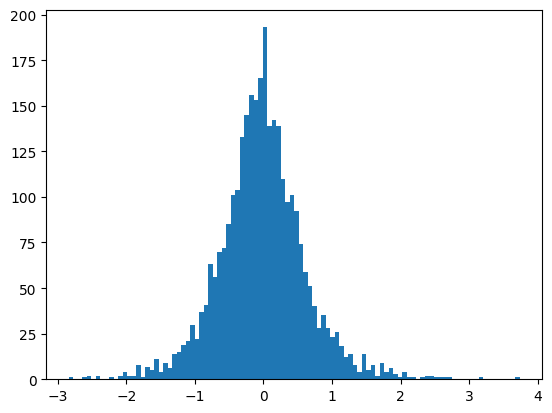

In [33]:
print(z.mean(), z.std())
z_cpu = z.detach().cpu().numpy()
plt.hist(z_cpu.flatten(), bins=100)

In [18]:
import torch
b = 16
x = torch.randn((b, 3, 32, 32)).cuda()
t = torch.randn((b,)).cuda()
print(t)
texp = t.view([b, *([1] * len(x.shape[1:]))])
print(texp)
z1 = torch.randn_like(x)
zt = (1 - texp) * x + texp * z1
zt = zt.cuda()
cond = torch.arange(0, 16).cuda() % 10
vtheta = model(zt, t, cond)
print(vtheta.shape)
batchwise_mse = ((z1 - x - vtheta) ** 2).mean(dim=list(range(1, len(x.shape))))
print(batchwise_mse.shape)
tlist = batchwise_mse.detach().cpu().reshape(-1).tolist()
print(tlist)
ttloss = [(tv, tloss) for tv, tloss in zip(t, tlist)]
print(ttloss)

tensor([-0.1484, -1.7467, -0.2888, -0.7391,  0.8877, -0.2381, -0.0610, -1.4231,
         0.1360,  0.3287,  1.2306,  0.0084, -0.3247, -0.4898, -0.1750, -0.4527],
       device='cuda:0')
tensor([[[[-0.1484]]],


        [[[-1.7467]]],


        [[[-0.2888]]],


        [[[-0.7391]]],


        [[[ 0.8877]]],


        [[[-0.2381]]],


        [[[-0.0610]]],


        [[[-1.4231]]],


        [[[ 0.1360]]],


        [[[ 0.3287]]],


        [[[ 1.2306]]],


        [[[ 0.0084]]],


        [[[-0.3247]]],


        [[[-0.4898]]],


        [[[-0.1750]]],


        [[[-0.4527]]]], device='cuda:0')
torch.Size([16, 3, 32, 32])
torch.Size([16])


In [19]:
print(len(x.shape))

4
